# Caso Grupal: Detección de anomalías y técnicas de agrupamiento

In [ ]:
!rm -rf *
!git clone https://github.com/MiguelJG/Lab1_AprendizajeAutomatico.git
!mv /content//Lab1_AprendizajeAutomatico/creditcardcsvpresent.csv /content/
!rm -rf /Lab1_AprendizajeAutomatico

Cloning into 'Lab1_AprendizajeAutomatico'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


## 1. Análisis descriptivo de los datos


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

**Leemos los datos del dataset**

In [ ]:
df = pd.read_csv('creditcardcsvpresent.csv')
df.head()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Merchant_id                     3075 non-null   int64  
 1   Transaction date                0 non-null      float64
 2   Average Amount/transaction/day  3075 non-null   float64
 3   Transaction_amount              3075 non-null   float64
 4   Is declined                     3075 non-null   object 
 5   Total Number of declines/day    3075 non-null   int64  
 6   isForeignTransaction            3075 non-null   object 
 7   isHighRiskCountry               3075 non-null   object 
 8   Daily_chargeback_avg_amt        3075 non-null   int64  
 9   6_month_avg_chbk_amt            3075 non-null   float64
 10  6-month_chbk_freq               3075 non-null   int64  
 11  isFradulent                     3075 non-null   object 
dtypes: float64(4), int64(4), object(4)

**Se obtienen los histogramas de las variables numéricas**

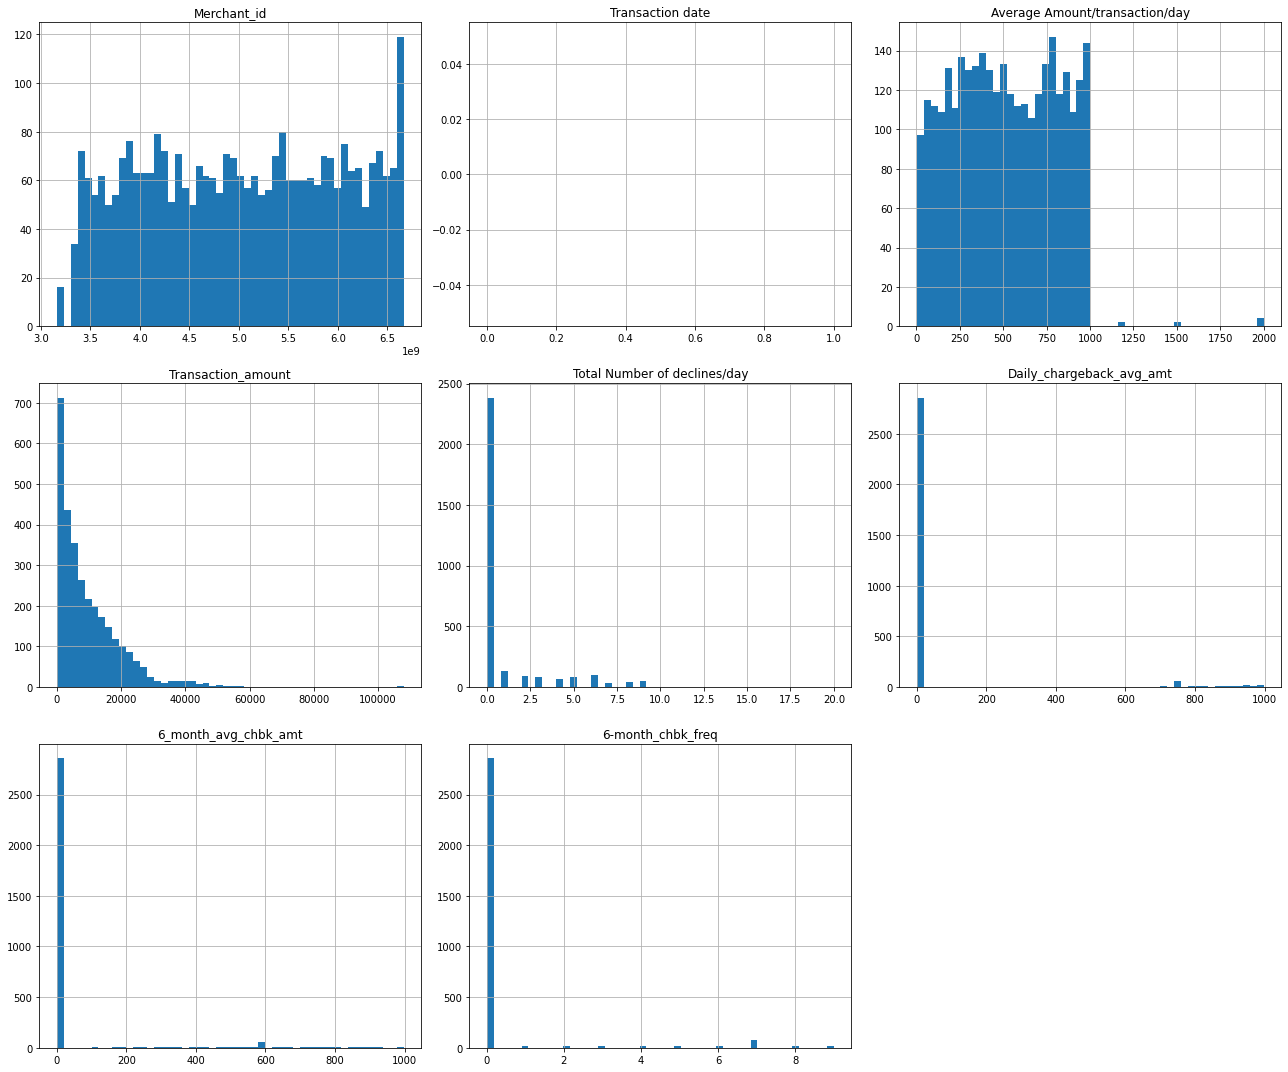

In [ ]:
df.hist(bins=50, figsize=(18,15))
plt.tight_layout()
plt.show()

**De las variables numéricas hallar datos estadísticos: máximo, mínimo, media, mediana y cuartiles**

In [ ]:
df.describe()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq
count,3.075000e+03,0.0,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000
mean,5.026634e+09,NaN,515.026556,9876.399210,0.957398,55.737561,40.022407,0.391870
std,9.870778e+08,NaN,291.906978,10135.331016,2.192391,206.634779,155.968840,1.548479
min,3.160041e+09,NaN,4.011527,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.170814e+09,NaN,269.788047,2408.781147,0.000000,0.000000,0.000000,0.000000
50%,5.025578e+09,NaN,502.549575,6698.891856,0.000000,0.000000,0.000000,0.000000
75%,5.889625e+09,NaN,765.272803,14422.568935,0.000000,0.000000,0.000000,0.000000
max,6.665906e+09,NaN,2000.000000,108000.000000,20.000000,998.000000,998.000000,9.000000


**De las variables categóricas, listamos las diferentes categorías y hallamos la frecuencia de cada una de ellas**

In [ ]:
df_categorical = df.select_dtypes(include=['object']).copy()

In [ ]:
for column in df_categorical:
    print("\n" + column)
    print(df_categorical[column].value_counts())


Is declined
N    3018
Y      57
Name: Is declined, dtype: int64

isForeignTransaction
N    2369
Y     706
Name: isForeignTransaction, dtype: int64

isHighRiskCountry
N    2870
Y     205
Name: isHighRiskCountry, dtype: int64

isFradulent
N    2627
Y     448
Name: isFradulent, dtype: int64


**Crear la matriz de correlaciones con las columnas numéricas**

In [ ]:
matriz_corr = df.corr()

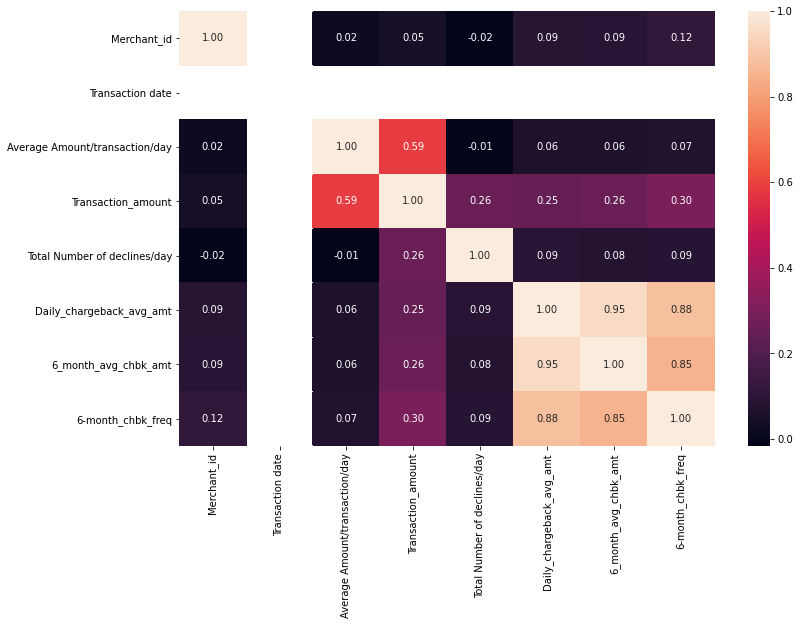

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(matriz_corr,annot=True, fmt='.2f');

**Encontramos las correlaciones más altas, que superen el 0.75**

In [ ]:
parejas_correlacionadas = matriz_corr.unstack()
parejas_ordenadas = parejas_correlacionadas.sort_values(kind="quicksort")
parejas_ordenadas = parejas_ordenadas[parejas_ordenadas != 1]
parejas_corr_alta = parejas_ordenadas[parejas_ordenadas > 0.75]

tempSerie = pd.Series([],dtype="float64")
templist = []
for index_, value in parejas_corr_alta.items():
    if value not in templist:
        templist.append(value)
        tempSerie = tempSerie.append(parejas_corr_alta.loc[[index_]])

parejas_corr_alta = tempSerie
del(templist)
del(tempSerie)
print(parejas_corr_alta)

(6_month_avg_chbk_amt, 6-month_chbk_freq)           0.851339
(Daily_chargeback_avg_amt, 6-month_chbk_freq)       0.884611
(Daily_chargeback_avg_amt, 6_month_avg_chbk_amt)    0.953663
dtype: float64


**Revisamos las correlaciones más altas y decidimos si eliminar o no la columna**

In [ ]:
to_drop = ['6_month_avg_chbk_amt', '6-month_chbk_freq']

df.drop(columns = to_drop, axis=1, inplace=True)

## 2. Tratamiento de missing

In [ ]:
df.isnull().sum()

Merchant_id                          0
Transaction date                  3075
Average Amount/transaction/day       0
Transaction_amount                   0
Is declined                          0
Total Number of declines/day         0
isForeignTransaction                 0
isHighRiskCountry                    0
Daily_chargeback_avg_amt             0
isFradulent                          0
dtype: int64

Como se puede observar, sólo hay una variable con valores faltantes: la variable 'Transaction date'. Esta variable sólo tiene valores nulos, por lo que se decide eliminarla.

In [ ]:
df.drop(columns = 'Transaction date', axis=1, inplace=True)

Se elimina la variable "Merchant_id", ya que el identificador no está aportando información.

In [ ]:
df.drop(columns = 'Merchant_id', axis=1, inplace=True)

**Box plot de las variables numéricas**

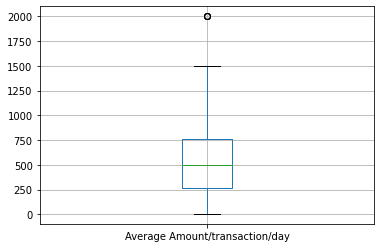

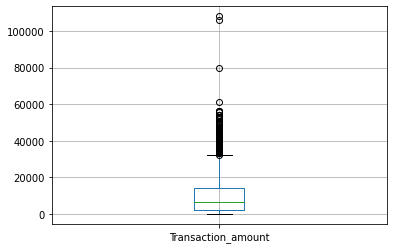

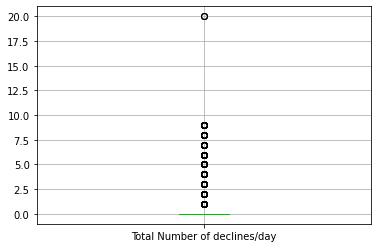

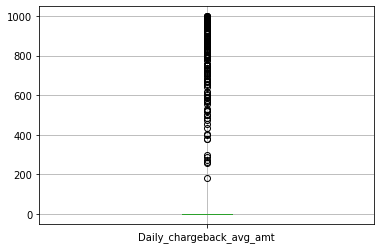

In [ ]:
col_nombres=[]
for col in df.columns: 
  if col not in df_categorical.columns:
    col_nombres.append(col)
    boxplot = df.boxplot(column=col)
    plt.show()

## 3. Problema de cluster o agrupamiento

**Se crean al menos dos modelos con grupos diferentes para poder compararlos**

In [ ]:
columns = df.select_dtypes(include=['object']).columns
print(columns)

Index(['Is declined', 'isForeignTransaction', 'isHighRiskCountry',
       'isFradulent'],
      dtype='object')


In [ ]:
# Get dummies
df = pd.get_dummies(df, columns=columns, drop_first=True)
df.head()

,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,Is declined_Y,isForeignTransaction_Y,isHighRiskCountry_Y,isFradulent_Y
0,100.0,3000.0,5,0,0,1,1,1
1,100.0,4300.0,5,0,0,1,1,1
2,185.5,4823.0,5,0,1,0,0,1
3,185.5,5008.5,8,0,1,0,0,1
4,500.0,26000.0,0,800,0,1,1,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


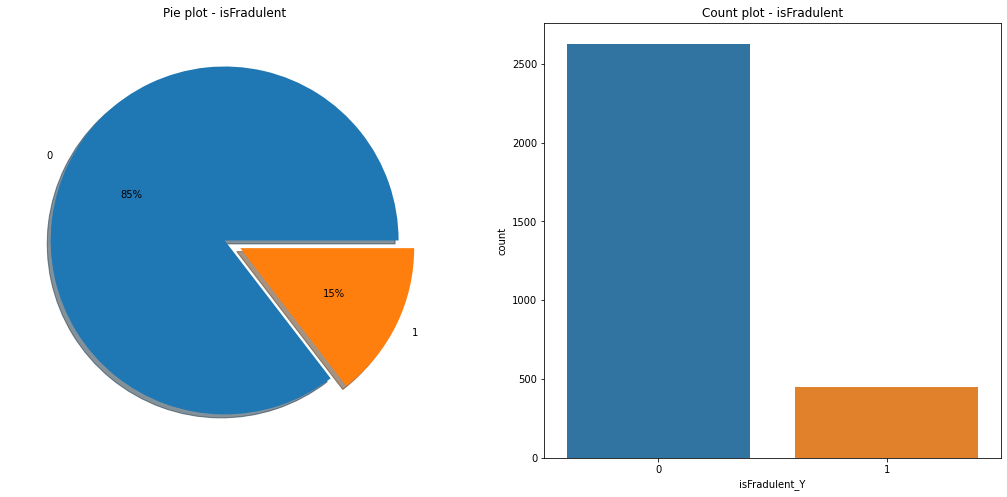

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df['isFradulent_Y'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - isFradulent')
ax[0].set_ylabel('')
sns.countplot('isFradulent_Y', data=df, ax=ax[1])
ax[1].set_title('Count plot - isFradulent')

plt.show();

In [ ]:


X_df = df[df.columns[:-1]]
Y_df = df['isFradulent_Y']
#Escalamos los datos
scaler = StandardScaler() 
scaler.fit(X_df) 
X_df_scaled = scaler.transform(X_df)

df_scaled = pd.DataFrame(X_df_scaled ,  columns=X_df.columns)

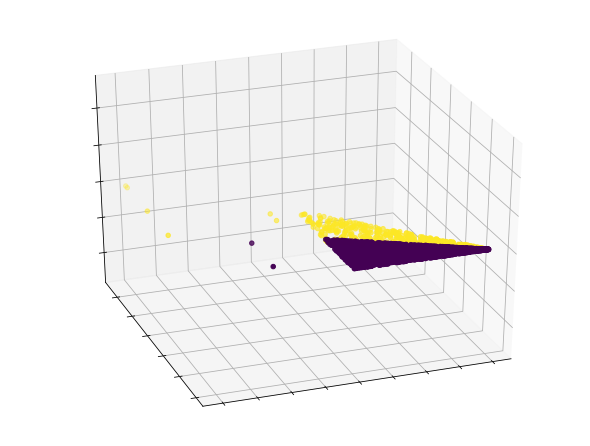

In [ ]:
# Creamos una figura.
fig = plt.figure(1, figsize=(8, 6))
# De tipo 3D
ax = Axes3D(fig, elev=-150, azim=110)
# Y representamos los diferentes puntos
ax.scatter(X_df.iloc[:,0], X_df.iloc[:,1],c=df['isFradulent_Y'])


ax.w_xaxis.set_ticklabels([])

ax.w_yaxis.set_ticklabels([])

_ = ax.w_zaxis.set_ticklabels([])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[16625.22781062982, 13536.77397879983, 10930.855176747446, 8819.764953578571, 7043.129115042141, 5944.766500527422, 5539.367299330609, 5146.9388134943, 4809.198815418809, 4449.118323110265, 4154.187476207437, 3980.194865441149]


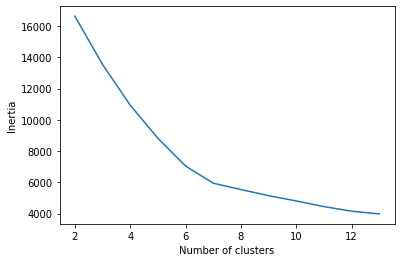

In [ ]:
n_clusters=[]
inertia=[]

for n in range(2,14):
    n_clusters.append(n)
    k_means = cluster.KMeans(n_clusters=n)
    k_means.fit(X_df_scaled)
    inertia.append(k_means.inertia_)

print(n_clusters)
print(inertia)

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters,inertia)

La inercia nos indica cómo de alejados están los puntos dentro de un mismo cluster. Ésta disminuye a medida que se aumenta el número de clusteres y un criterio que se suele aplicar para escoger este número es ver el punto de inflexión a partir del cual la inercia ya no disminye tan significativamente. Aunque en esta imagen podamos observar que el punto de inflexión se encontraría aproximadamente en 7, no es un buen criterio para determinar el número de clusters ya que las clases no están balanceadas, es decir, queremos detectar anomalías.

Comprobamos que para 7 clústers los resultados no son buenos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df_scaled, Y_df, test_size=0.2)
k_means = cluster.KMeans(n_clusters=7)
k_means.fit(X_train)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
y_pred = k_means.predict(X_test)

In [ ]:
y_pred_df = pd.DataFrame(y_pred)

y_pred_df.value_counts()

6    216
1    189
5     99
4     37
0     33
3     30
2     11
dtype: int64

In [ ]:
print('Accuracy Score: \n', metrics.accuracy_score(y_test,y_pred ))
print(metrics.classification_report(y_test,y_pred )) # Reporte de clasificación
print('Confusion matrix: \n', metrics.confusion_matrix(y_test,y_pred ))

Accuracy Score: 
 0.02926829268292683
              precision    recall  f1-score   support

           0       0.52      0.03      0.06       535
           1       0.01      0.01      0.01        80
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.03       615
   macro avg       0.07      0.01      0.01       615
weighted avg       0.45      0.03      0.05       615

Confusion matrix: 
 [[ 17 188   3   0  21  90 216]
 [ 16   1   8  30  16   9   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f87c58afb10>],
      dtype=object)

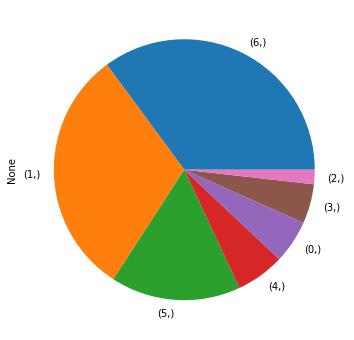

In [ ]:
y_pred_df.value_counts().plot.pie(subplots=True, figsize=(11, 6))

**Se imprimen los centroides de los grupos de este modelo**

In [ ]:
centroides = k_means.cluster_centers_
labels = k_means.labels_
print(labels)
print(centroides)

[4 1 6 ... 6 5 1]
[[ 0.0306198   0.3690929   2.36559198 -0.26978337 -0.13742882  0.09569783
  -0.26726124]
 [ 0.88643519  0.21923683 -0.3687542  -0.26620746 -0.13742882 -0.54590845
  -0.26726124]
 [ 0.61984695  1.5561698   0.85249058  2.90373279  7.27649424  0.53957124
   0.77854362]
 [-0.06896812  1.11721862  1.18393823 -0.18861376 -0.13742882  1.83180896
   3.74165739]
 [ 0.13397634  0.93670756  0.48370627  3.77083475 -0.13742882 -0.01986478
  -0.05439831]
 [ 0.08041715 -0.04631808 -0.28620235 -0.26131693 -0.13742882  1.83180896
  -0.26726124]
 [-0.8040935  -0.61648189 -0.34440666 -0.25883225 -0.13742882 -0.54590845
  -0.26726124]]


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


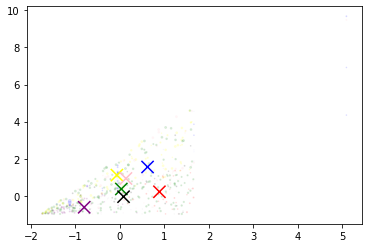

In [ ]:
colors = ["green","red","blue","yellow","pink", "black", "purple"]
centroids_x = centroides[:,0]
centroids_y = centroides[:,1]

X_train_df = pd.DataFrame(X_train, columns = df_scaled.columns)
plt.scatter(X_train_df.iloc[:,0], X_train_df.iloc[:,1], X_train_df.iloc[:,2], c=np.array(colors)[labels], alpha=.1)
plt.scatter(centroids_x,centroids_y,marker = "x", s=150,linewidths = 5, zorder = 10, c=colors)

Como vemos los grupos que se han obtenido no siguen la lógica que buscábamos para detectar anomalías. 

**Segundo modelo**

Probaremos ahora con dos clústeres 

In [ ]:
k_means = cluster.KMeans(n_clusters=2)
k_means.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
y_pred = k_means.predict(X_test)

In [ ]:
y_pred_df = pd.DataFrame(y_pred)

y_pred_df.value_counts()

0    554
1     61
dtype: int64



Hacemos un plot pie de los valores predichos



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f87c57aeb50>],
      dtype=object)

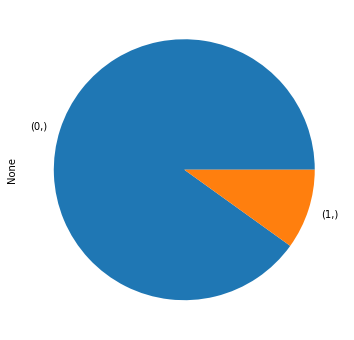

In [ ]:
y_pred_df.value_counts().plot.pie(subplots=True, figsize=(11, 6))

In [ ]:

print('Accuracy Score \n:', metrics.accuracy_score(y_test,y_pred ))
print(metrics.classification_report(y_test,y_pred )) # Reporte de clasificación
print('Confusion matrix \n:', metrics.confusion_matrix(y_test,y_pred ))

Accuracy Score 
: 0.9463414634146341
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       535
           1       0.89      0.68      0.77        80

    accuracy                           0.95       615
   macro avg       0.92      0.83      0.87       615
weighted avg       0.94      0.95      0.94       615

Confusion matrix 
: [[528   7]
 [ 26  54]]


Como podemos observar los resultados son mucho mejores. En la matriz de confusión vemos que nos ha clasificado 26 anomalías como no anomalías y 7 que no son anomalías nos lo ha clasificado como anomalías. Esto nos indica que, aunque a priori son buenos resultados, siempre sería mejor que en este tipo de casos nos detectara anomalías aunque no lo sean y no que no nos detectara como anomalías cuando si lo sean. Es decir, minimizar los falsos negativos (los que no detectamos como anomalía que si lo son, en este caso 26) a costa de que aumente el número de falsos positivos que son los que detectamos como anomalías pero no lo son.  Por lo tanto, es preferible tener más falsos positivos que falsos negativos para poder detectar mejor las anomalías. 

**Se imprimen los centroides de los grupos de este modelo**

In [ ]:
centroides = k_means.cluster_centers_
labels = k_means.labels_
print(labels.size)
print(centroides)

2460
[[-0.02649165 -0.18156598 -0.15894068 -0.13748412 -0.13062393 -0.19454315
  -0.26726124]
 [ 0.24941566  1.46110227  1.3928969   0.94640962  1.02347017  1.40026594
   2.1580632 ]]


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


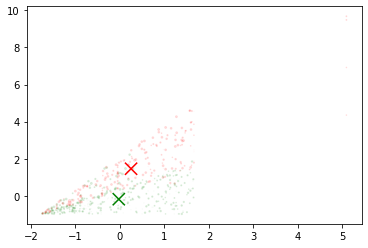

In [ ]:
colors = ["green","red"]
centroids_x = centroides[:,0]
centroids_y = centroides[:,1]

X_train_df = pd.DataFrame(X_train, columns = df_scaled.columns)
plt.scatter(X_train_df.iloc[:,0], X_train_df.iloc[:,1], X_train_df.iloc[:,2], c=np.array(colors)[labels], alpha=.1)
plt.scatter(centroids_x,centroids_y,marker = "x", s=150,linewidths = 5, zorder = 10, c=colors)

## 4. Detección de anomalías

**Se utiliza el algoritmo Isolation Forest**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.2)

Escogemos el parámetro *contamination* a 0.15 ya que como hemos observado en el gráfico que nos mostraba los porcentajes de anomalías en las observaciones, este era del 15%.

In [ ]:
modelo_isof = IsolationForest(
                n_estimators  = 2000, # Número de árboles del modelo
                max_samples   ='auto', # 
                contamination = 0.15, # Proporción de anomalías esperadas en los datos de entrenamiento
                n_jobs        = -1,
                random_state  = 123, # Semilla
            )

modelo_isof.fit(X=X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.15,
                max_features=1.0, max_samples='auto', n_estimators=2000,
                n_jobs=-1, random_state=123, verbose=0, warm_start=False)

**Se obtiene el score**

In [ ]:
y_pred_train = modelo_isof.predict(X=X_train)
y_pred_train # -1 anomalia, 1 no anomalía

array([ 1,  1,  1, ..., -1,  1,  1])

In [ ]:
score_anomalia_train = modelo_isof.score_samples(X=X_train)
score_anomalia_train # Cuanto más cercano a -1, mayor evidencia de anomalía. Valores entre -0,5 y 0 -> observaciones normales.

array([-0.37811158, -0.38702266, -0.49449698, ..., -0.55445546,
       -0.36985967, -0.39488482])

In [ ]:
score_train = np.quantile(score_anomalia_train, q=0.1)
score_train

-0.5912081639711256

**Se hallan el máximo score y el mínimo score**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


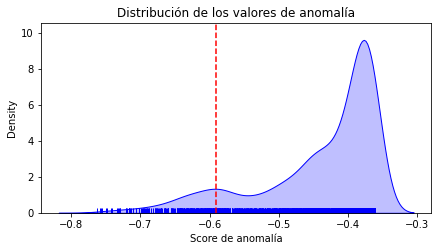

In [ ]:
# Distribución de los valores de anomalía para los datos de train
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.distplot(
    score_anomalia_train,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.axvline(score_train, c='red', linestyle='--', label='score')
ax.set_title('Distribución de los valores de anomalía')
ax.set_xlabel('Score de anomalía');

In [ ]:
np.max(score_anomalia_train) # Score máximo

-0.36018171897933676

In [ ]:
np.min(score_anomalia_train) # Score mínimo, esperado para mayor evidencia de anomalía

-0.7628391334814787

**Se calcula el score para los datos de test**

Para ello se repiten los pasos anteriores, los seguidos para el score en train:

In [ ]:
y_pred_test = modelo_isof.predict(X=X_test)
score_anomalia_test = modelo_isof.score_samples(X=X_test)
score_test = np.quantile(score_anomalia_test, q=0.1)
score_test

-0.5988680513182743

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


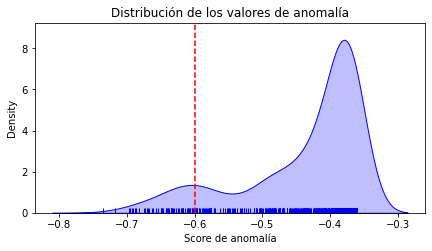

In [ ]:
# Distribución de los valores de anomalía para los datos de train
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.distplot(
    score_anomalia_test,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.axvline(score_test, c='red', linestyle='--', label='score')
ax.set_title('Distribución de los valores de anomalía')
ax.set_xlabel('Score de anomalía');

In [ ]:
np.max(score_anomalia_test) # Score máximo

-0.36061840866820355

In [ ]:
np.min(score_anomalia_test) # Score mínimo

-0.7354329542186919

**Se obtiene la matriz de confusión en los datos de train y en los datos de test**

Resultados en los datos de train:

In [ ]:
df_resultados_train = pd.DataFrame({
                    'score'    : score_anomalia_train,
                    'anomalia' : y_train

                })

In [ ]:

df_resultados_train['clasificacion'] = np.where(y_pred_train < 0, 1, 0)

pd.crosstab(
    df_resultados_train.anomalia,
    df_resultados_train.clasificacion
)

clasificacion,0,1
anomalia,,
0,2041,66
1,50,303


In [ ]:
print('Accuracy Score:', metrics.accuracy_score(df_resultados_train.anomalia,df_resultados_train.clasificacion))
print(metrics.classification_report(df_resultados_train.anomalia,df_resultados_train.clasificacion)) # Reporte de clasificación
print(roc_auc_score(df_resultados_train.anomalia, df_resultados_train.clasificacion))

Accuracy Score: 0.9528455284552846
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2107
           1       0.82      0.86      0.84       353

    accuracy                           0.95      2460
   macro avg       0.90      0.91      0.91      2460
weighted avg       0.95      0.95      0.95      2460

0.9135163914699551


Resultados en los datos de test:

In [ ]:
df_resultados_test = pd.DataFrame({
                    'score'    : score_anomalia_test,
                    'anomalia' : y_test
                })

In [ ]:

df_resultados_test['clasificacion'] = np.where(y_pred_test < 0, 1, 0)

pd.crosstab(
    df_resultados_test.anomalia,
    df_resultados_test.clasificacion
)

clasificacion,0,1
anomalia,,
0,509,11
1,8,87


In [ ]:
print('Accuracy Score:', metrics.accuracy_score(df_resultados_test.anomalia,df_resultados_test.clasificacion))
print( metrics.classification_report(df_resultados_test.anomalia,df_resultados_test.clasificacion)) # Reporte de clasificación

Accuracy Score: 0.9691056910569106
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       520
           1       0.89      0.92      0.90        95

    accuracy                           0.97       615
   macro avg       0.94      0.95      0.94       615
weighted avg       0.97      0.97      0.97       615



Como podemos observar los resultados son bastante buenos ya que tenemos un pequeño porcentaje de falsos negativos (solo 8 en comparación con 95 que son el total de anomalías). Por otro lado, tenemos solo 11 clasificados como falsos positivos. 


## 5. Comentarios sobre los resultados obtenidos en cluster y en anomalías

Aunque ambos modelos muestran unos resultados satisfactorios, ya que el accuracy es muy similar, podemos concluir que el de isolation forest sería mucho más útil. En este caso, obtenemos un número bastante menor de falsos negativos con lo cual es un buen resultado ya que buscamos que no pase por alto las anomalías aunque eso sea a costa de clasificar más falsos positivos. Con esto, estamos asumiendo que el coste de una anomalía no detectada es meyor que el del dato normal marcado como anomalía. 

## 6. Referencias

Amat.J, (2020). Detección de anomalías con Isolation Forest y python. https://www.cienciadedatos.net/documentos/py22-deteccion-anomalias-isolation-forest-python.html